In [ ]:
# default_exp data

# Data functionalities

> Generating and importing data

In [ ]:
import gzip
from fastai2.vision.all import *

## Loading external data
Most of the functions come from: https://github.com/jhhuang96/ConvLSTM-PyTorch

In [ ]:
#export
ROOT_PATH = Path.cwd().parent
DATA_PATH = Path.cwd().parent/'data'

In [ ]:
#export
def load_mnist():
    "Load MNIST dataset for generating training data"
    path = DATA_PATH/'train_images.gz'
    with gzip.open(path, 'rb') as f:
        mnist = np.frombuffer(f.read(), np.uint8, offset=16)
        mnist = mnist.reshape(-1, 28, 28)
    return mnist

In [ ]:
data = load_mnist()
test_eq(data.shape, [60000,28,28])

we can show some:

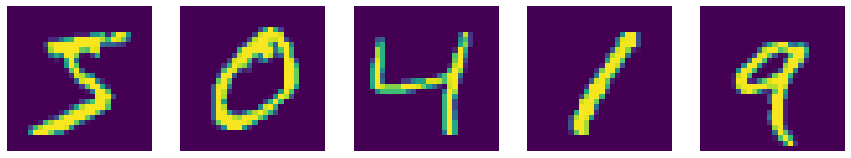

In [ ]:
show_images(data[0:5]);

In [ ]:

# def load_fixed_set(root, is_train):
#     # Load the fixed dataset
#     filename = 'mnist_test_seq.npy'
#     path = os.path.join(root, filename)
#     dataset = np.load(path)
#     dataset = dataset[..., np.newaxis]
#     return dataset


## Generating moving mnist sequences:

In [ ]:
class MovingMNIST:
    def __init__(self, root, n_frames_input, n_frames_output, num_objects):
        self.dataset = None
        self.mnist = load_mnist(root)
        self.length = int(1e4) if self.dataset is None else self.dataset.shape[1]

        self.is_train = is_train
        self.num_objects = num_objects
        self.n_frames_input = n_frames_input
        self.n_frames_output = n_frames_output
        self.n_frames_total = self.n_frames_input + self.n_frames_output
        # For generating data
        self.image_size_ = 64
        self.digit_size_ = 28
        self.step_length_ = 0.1

    def get_random_trajectory(self, seq_length):
        ''' Generate a random sequence of a MNIST digit '''
        canvas_size = self.image_size_ - self.digit_size_
        x = random.random()
        y = random.random()
        theta = random.random() * 2 * np.pi
        v_y = np.sin(theta)
        v_x = np.cos(theta)

        start_y = np.zeros(seq_length)
        start_x = np.zeros(seq_length)
        for i in range(seq_length):
            # Take a step along velocity.
            y += v_y * self.step_length_
            x += v_x * self.step_length_

            # Bounce off edges.
            if x <= 0:
                x = 0
                v_x = -v_x
            if x >= 1.0:
                x = 1.0
                v_x = -v_x
            if y <= 0:
                y = 0
                v_y = -v_y
            if y >= 1.0:
                y = 1.0
                v_y = -v_y
            start_y[i] = y
            start_x[i] = x

        # Scale to the size of the canvas.
        start_y = (canvas_size * start_y).astype(np.int32)
        start_x = (canvas_size * start_x).astype(np.int32)
        return start_y, start_x

    def generate_moving_mnist(self, num_digits=2):
        '''
        Get random trajectories for the digits and generate a video.
        '''
        data = np.zeros((self.n_frames_total, self.image_size_, self.image_size_), dtype=np.float32)
        for n in range(num_digits):
            # Trajectory
            start_y, start_x = self.get_random_trajectory(self.n_frames_total)
            ind = random.randint(0, self.mnist.shape[0] - 1)
            digit_image = self.mnist[ind]
            for i in range(self.n_frames_total):
                top = start_y[i]
                left = start_x[i]
                bottom = top + self.digit_size_
                right = left + self.digit_size_
                # Draw digit
                data[i, top:bottom, left:right] = np.maximum(data[i, top:bottom, left:right], digit_image)

        data = data[..., np.newaxis]
        return data

    def __getitem__(self, idx):
        length = self.n_frames_input + self.n_frames_output
        if self.is_train or self.num_objects[0] != 2:
            # Sample number of objects
            num_digits = random.choice(self.num_objects)
            # Generate data on the fly
            images = self.generate_moving_mnist(num_digits)
        else:
            images = self.dataset[:, idx, ...]
        r = 1
        w = int(64 / r)
        images = images.reshape((length, w, r, w, r)).transpose(0, 2, 4, 1, 3).reshape((length, r * r, w, w))

        input = images[:self.n_frames_input]
        if self.n_frames_output > 0:
            output = images[self.n_frames_input:length]
        else:
            output = []

        frozen = input[-1]
        output = torch.from_numpy(output / 255.0).contiguous().float()
        input = torch.from_numpy(input / 255.0).contiguous().float()
        out = [idx, output, input, frozen, np.zeros(1)]
        return out

    def __len__(self):
        return self.length